# Applying Finite DMRG to Kitaev Ladder Model

In this notebook, we will begin our trial of finite DMRG on Kitaev ladders.

Firstly, we will carry a demo copied from the official examples, and checked the following conclusion using Ising model:

 - the typical distribution of entanglement over unit cells of a gapped state
 - the typical distribution of entanglement over unit cells of a gapless state
 
Secondly, we will carry the finite DMRG over a confirmed gapless state of Kitaev ladder, the double Kitaev string `J = (1, 1, 0)`, and a confirmed gapped state, `(a, b) = (.75, .5)`;
 


## Finite DMRG formula

$$ S(x, L) = \frac{c}{6} \ln \left[ \frac{2L}{\pi} \sin(\frac{\pi x}{L}) \right] + \ln g + s_1 / 2 $$

## The demo usage of finite DMRG in TeNPy

In [1]:
import numpy as np
from random import choice
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate

from matplotlib.pyplot import *
from scipy.optimize import curve_fit, leastsq

In [2]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.spins import SpinModel
from tenpy.algorithms import dmrg

In [3]:
from numpy import pi
from kitaev_ladder import KitaevLadderModel, load_data, run_atomic, save_after_run, KitaevLadder, finite_scaling
from rotation import get_xyz, decimals
# path toolkits
from pathlib import Path

In [4]:
def finite_gs_energy(L, J, g):
    """For comparison: obtain ground state energy from exact diagonalization.
    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_xx = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_xx = H_xx + sx_list[i] * sx_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
    H = -J * H_xx - g * H_z
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return E[0]


In [4]:
def example_DMRG_tf_ising_finite(L, g, verbose=True):
    print("finite DMRG, transverse field Ising model")
    print("L={L:d}, g={g:.2f}".format(L=L, g=g))
    model_params = dict(L=L, J=1., g=g, bc_MPS='finite', conserve=None, verbose=verbose)
    M = TFIChain(model_params)
    product_state = ["up"] * M.lat.N_sites
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': True
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
    mag_x = np.sum(psi.expectation_value("Sigmax"))
    mag_z = np.sum(psi.expectation_value("Sigmaz"))
    print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
    print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
    if L < 20:  # compare to exact result
#         from tfi_exact import finite_gs_energy
        E_exact = finite_gs_energy(L, 1., g)
        print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
        print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M

## The gapless Ising

In [5]:
E, psi, M = example_DMRG_tf_ising_finite(L=10, g=1., verbose=True)

finite DMRG, transverse field Ising model
L=10, g=1.00
Reading 'bc_MPS'='finite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=10 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=1.0 for config TFIChain
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 10
Energy = -12.3814899996547751, S = 0.3370841145840079, norm_err = 6.4e-15
Current memory usage 105.2 MB, time elapsed: 1.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 9.8706e-21, max_E_trunc = 1.4211e-14
MPS bond dimensions: [2, 4, 8, 14, 19, 14, 8, 4, 2]
sweep 20, age = 10
Energy = -12.3814899996547663, S = 0.3370841145840076, norm_err = 9.5e-15
Current memory usage 105.2 MB, time elapsed: 2.0 s
Delta E = 8.8818e-16, Delta S = -3.3307e-17 (per sweep)
max_trunc_err = 9.8706e-21, max_E_trunc = 5.3291e-15
MPS bond d

In [6]:
entanglement_entropy = psi.entanglement_entropy()
entanglement_spectrum = psi.entanglement_spectrum()

In [7]:
entanglement_entropy

array([0.26485952, 0.32877245, 0.35930702, 0.37441333, 0.37905241,
       0.37441333, 0.35930702, 0.32877245, 0.26485952])

In [8]:
entanglement_spectrum

[array([0.07730669, 2.59837909]),
 array([ 0.10648949,  2.29439336,  8.659313  , 10.84721688]),
 array([ 0.1217556 ,  2.17009021,  7.78873602,  9.83707063, 15.82878799,
        17.8771226 , 23.49576841, 25.54410302]),
 array([ 0.12957971,  2.11313206,  7.42800359,  9.41155593, 14.72907782,
        16.71263016, 22.02750169, 24.01105404, 24.29541742, 26.27896976,
        31.5938418 , 33.57739581, 38.89494311, 40.87936836]),
 array([ 0.1320149 ,  2.09622416,  7.32434428,  9.28855354, 14.4364347 ,
        16.40064396, 21.62876408, 23.54650688, 23.59297335, 25.51071614,
        30.73883633, 32.70304675, 35.46322309, 37.42743313, 37.85093981,
        39.81532374, 42.65595721, 44.62018793, 45.03992791]),
 array([ 0.12957971,  2.11313206,  7.42800359,  9.41155593, 14.72907782,
        16.71263016, 22.02750169, 24.01105404, 24.29541742, 26.27896976,
        31.59384183, 33.57739584, 38.89494387, 40.87936845]),
 array([ 0.1217556 ,  2.17009021,  7.78873602,  9.83707063, 15.82878799,
        17.8

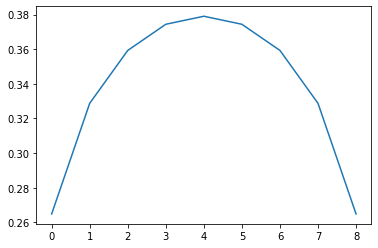

In [11]:
plot(entanglement_entropy)

In [45]:
L = 100
E, psi, M = example_DMRG_tf_ising_finite(L=L, g=1., verbose=True)
entanglement_entropy = psi.entanglement_entropy()

finite DMRG, transverse field Ising model
L=100, g=1.00
Reading 'bc_MPS'='finite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=100 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=1.0 for config TFIChain
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 100
Energy = -126.9618767395063657, S = 0.5277993943516751, norm_err = 9.6e-10
Current memory usage 293.1 MB, time elapsed: 21.3 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 6.7100e-13, max_E_trunc = 5.1301e-12
MPS bond dimensions: [2, 4, 8, 16, 22, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

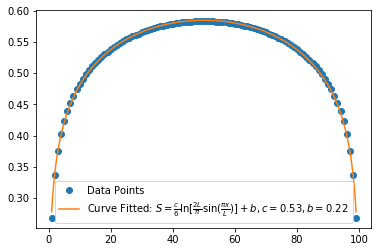

In [47]:
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()


## Gapped Ising

In [48]:
L = 100
g = .5
E, psi, M = example_DMRG_tf_ising_finite(L=L, g=g, verbose=True)
entanglement_entropy = psi.entanglement_entropy()

finite DMRG, transverse field Ising model
L=100, g=0.50
Reading 'bc_MPS'='finite' for config TFIChain
Reading 'conserve'=None for config TFIChain
Reading 'L'=100 for config TFIChain
Reading 'J'=1.0 for config TFIChain
Reading 'g'=0.5 for config TFIChain
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 100
Energy = -105.4837699496445680, S = 0.0035607045280003, norm_err = 1.0e-13
Current memory usage 303.2 MB, time elapsed: 12.5 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 1.2456e-20, max_E_trunc = 1.4211e-13
MPS bond dimensions: [2, 4, 8, 11, 12, 13, 14, 13, 13, 12, 12, 12, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

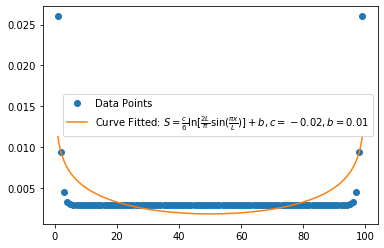

In [49]:
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()


Now we basically know how to carry the finite DMRG on Ising model.

Let's do something over our Kitaev ladders!

## Kitaev Ladder

### Design the finite DMRG function for Kitaev ladders

In [6]:
def fDMRG_KL(Jx, Jy, Jz, L, chi=100, verbose=True, order='default', bc_MPS='finite', bc='open'):
    """
        The finite DMRG for Kitaev Ladders
    """
    
    print("finite DMRG, Kitaev ladder model")
    print("L = {L:d}, Jx = {Jx:.2f}, Jy = {Jy:.2f}, Jz = {Jz:.2f}, ".format(L=L, Jx=Jx, Jy=Jy, Jz=Jz))
    model_params = dict(L=L, Jx=Jx, Jy=Jy, Jz=Jz, bc_MPS=bc_MPS, bc=bc, conserve=None, order=order, verbose=verbose)
    M = KitaevLadderModel(model_params)
    
    print("bc_MPS = ", M.lat.bc_MPS)
    
    product_state = [np.random.choice(["up", "down"]) for i in range(M.lat.N_sites)]
    psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
    dmrg_params = {
#         'mixer': None,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 50
        },
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': chi,
            'svd_min': 1.e-10
        },
        'verbose': verbose,
        'combine': True
    }
    info = dmrg.run(psi, M, dmrg_params)  # the main work...
    E = info['E']
    print("E = {E:.13f}".format(E=E))
    print("final bond dimensions: ", psi.chi)
#     mag_x = np.sum(psi.expectation_value("Sigmax"))
#     mag_z = np.sum(psi.expectation_value("Sigmaz"))
#     print("magnetization in X = {mag_x:.5f}".format(mag_x=mag_x))
#     print("magnetization in Z = {mag_z:.5f}".format(mag_z=mag_z))
#     if L < 20:  # compare to exact result
# #         from tfi_exact import finite_gs_energy
#         E_exact = finite_gs_energy(L, 1., g)
#         print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))
#         print("relative error: ", abs((E - E_exact) / E_exact))
    return E, psi, M

In [7]:
Jx = -1
Jy = 1
Jz = -1
L = 60
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 60, Jx = -1.00, Jy = 1.00, Jz = -1.00, 
Reading 'L'=60 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=-1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 240
Energy = -50.1886846544580294, S = nan, norm_err = 1.6e-09
Current memory usage 544.6 MB, time elapsed: 199.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1256e-16, max_E_trunc = 1.9185e-13
MPS bond di

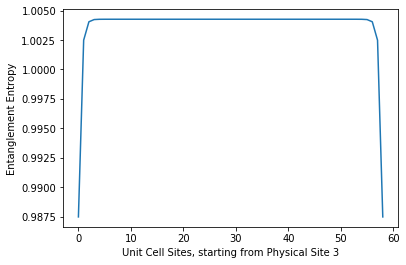

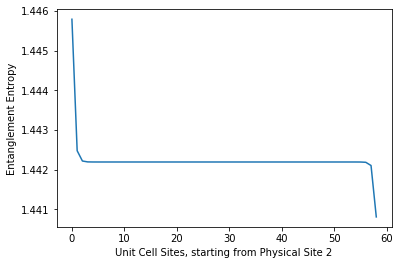

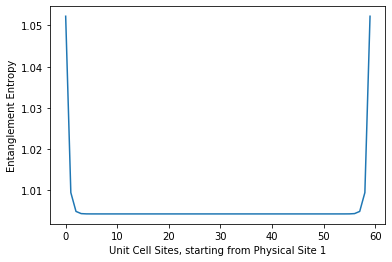

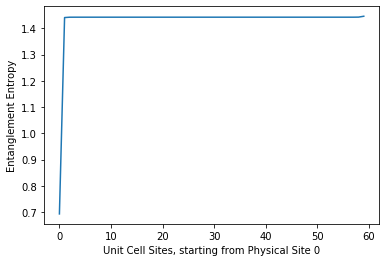

In [8]:
entanglement_entropy_raw = psi.entanglement_entropy()
# len(entanglement_entropy_raw)
start = 3
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 2
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 1
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 0
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

Extract the low-lying excitations

In [15]:
bc_MPS='finite'
bc = 'open'
order = 'default'
verbose = 1

chi = 100

model_params = dict(L=L, Jx=Jx, Jy=Jy, Jz=Jz, bc_MPS=bc_MPS, bc=bc, conserve=None, order=order, verbose=verbose)
M = KitaevLadderModel(model_params)

print("bc_MPS = ", M.lat.bc_MPS)

product_state = [np.random.choice(["up", "down"]) for i in range(M.lat.N_sites)]
init_psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
dmrg_params = {
#         'mixer': None,  # setting this to True helps to escape local minima
    'mixer': True,
    'mixer_params': {
        'amplitude': 1.e-4,
        'decay': 1.2,
        'disable_after': 50
    },
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': chi,
        'svd_min': 1.e-10
    },
    'verbose': verbose,
    'combine': True,
    'orthogonal_to': [psi],
}
info = dmrg.run(init_psi, M, dmrg_params)  # the main work...
E = info['E']
print("E = {E:.13f}".format(E=E))
print("final bond dimensions: ", init_psi.chi)

Reading 'L'=60 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=-1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f161558c390>] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 240
Energy = -50.1886846544578802, S = nan, norm_err = 1.7e-09
Current memory usage 625.2 MB, time elapsed: 223.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0705e-16, max_E_trunc = 2.7001e

In [16]:
Jx = -1
Jy = -1
Jz = -1
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = -1.00, Jy = -1.00, Jz = -1.00, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=-1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -83.7408840917021706, S = nan, norm_err = 2.1e-09
Current memory usage 874.0 MB, time elapsed: 336.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2699e-16, max_E_trunc = 3.5527e-13
MPS bon

DMRG finished after 40 sweeps.
total size = 400, maximum chi = 100
E = -83.7408840916984
final bond dimensions:  [2, 4, 8, 8, 16, 16, 32, 32, 60, 54, 88, 72, 100, 82, 100, 90, 100, 94, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 

In [17]:
bc_MPS='finite'
bc = 'open'
order = 'default'
verbose = 1

chi = 100

model_params = dict(L=L, Jx=Jx, Jy=Jy, Jz=Jz, bc_MPS=bc_MPS, bc=bc, conserve=None, order=order, verbose=verbose)
M = KitaevLadderModel(model_params)

print("bc_MPS = ", M.lat.bc_MPS)

product_state = [np.random.choice(["up", "down"]) for i in range(M.lat.N_sites)]
init_psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)
dmrg_params = {
#         'mixer': None,  # setting this to True helps to escape local minima
    'mixer': True,
    'mixer_params': {
        'amplitude': 1.e-4,
        'decay': 1.2,
        'disable_after': 50
    },
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': chi,
        'svd_min': 1.e-10
    },
    'verbose': verbose,
    'combine': True,
    'orthogonal_to': [psi],
}
info = dmrg.run(init_psi, M, dmrg_params)  # the main work...
E = info['E']
print("E = {E:.13f}".format(E=E))
print("final bond dimensions: ", init_psi.chi)

Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=-1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1615714510>] for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -83.7408840917026964, S = nan, norm_err = 3.1e-09
Current memory usage 994.4 MB, time elapsed: 376.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.2678e-16, max_E_trunc = 2.842

DMRG finished after 40 sweeps.
total size = 400, maximum chi = 100
E = -83.7408840916981
final bond dimensions:  [2, 4, 8, 8, 16, 16, 32, 32, 60, 54, 88, 72, 100, 82, 100, 90, 100, 94, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 96, 100, 

In [95]:
Jx = 1
Jy = 1
Jz = 2
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 1.00, Jz = 2.00, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=2 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -121.5015689228817166, S = nan, norm_err = 7.2e-09
Current memory usage 438.1 MB, time elapsed: 134.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.9739e-13, max_E_trunc = 1.4495e-12
MPS bond dim

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused options for config KitaevLadderSnakeModel:
['Jx', 'Jy', 'Jz', 'bc', 'bc_MPS']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused options for config KitaevLadderSnakeModel:
['Jx', 'Jy', 'Jz']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 30, age = 400
Energy = -121.5015689229799563, S = 1.1303739594631934, norm_err = 1.7e-10
Current memory usage 438.1 MB, time elapsed: 329.2 s
Delta E = -2.6247e-12, Delta S = nan (per sweep)
max_trunc_err = 5.6409e-14, max_E_trunc = 6.9633e-13
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 30, 26, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

The boundary input is unused, why? (fixed in the `Kitaev_ladder.py`

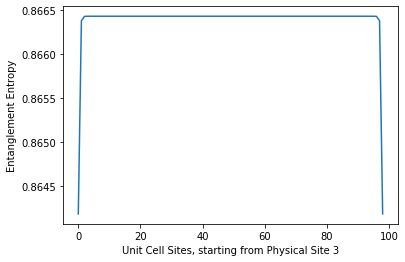

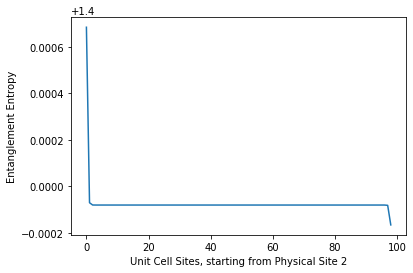

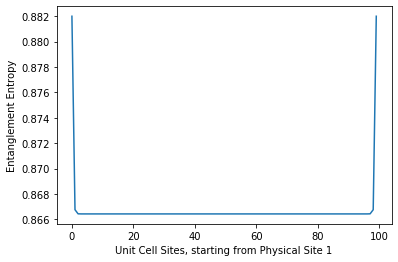

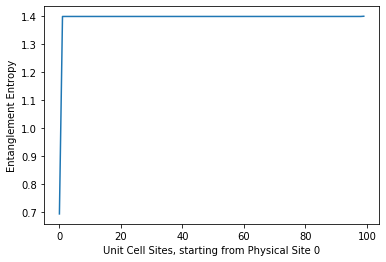

In [101]:
entanglement_entropy_raw = psi.entanglement_entropy()
# len(entanglement_entropy_raw)
start = 3
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 2
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 1
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 0
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

which apparently implies that this is a gapped state

## The following code turns out to be useless...

In [28]:
Jx = 1
Jy = 1
Jz = 2
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L, order='snake')

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 1.00, Jz = 2.00, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='snake' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=2 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 400
Energy = -121.4999701283707481, S = 1.2121159048103753, norm_err = 1.2e-07
Current memory usage 286.8 MB, time elapsed: 83.1 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 9.0226e-11, max_E_trunc = 4.3285e-10
MPS bond dimensions: [2, 4, 8, 8, 16, 14, 8, 4, 8, 8, 16, 16, 30, 30, 18, 9, 18, 24,

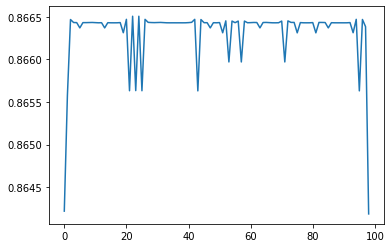

In [34]:
entanglement_entropy_raw = psi.entanglement_entropy()
# len(entanglement_entropy_raw)
plot(entanglement_entropy_raw[3:-1:4])

Same conclusion.

Try with gapless state

In [102]:
Jx = 1
Jy = 0
Jz = 1
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 0.00, Jz = 1.00, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=0 for config KitaevLadderModel
Reading 'Jz'=1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -63.5712953171079462, S = nan, norm_err = 2.0e+00
Current memory usage 438.1 MB, time elapsed: 202.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5640e-09, max_E_trunc = 1.0184e-09
MPS bond dime

sweep 50, age = 400
Energy = -63.5712953178867650, S = 0.7611904230531494, norm_err = 1.3e+00
Current memory usage 438.1 MB, time elapsed: 521.6 s
Delta E = -6.4162e-13, Delta S = -2.4032e-05 (per sweep)
max_trunc_err = 7.3529e-10, max_E_trunc = 9.9638e-10
MPS bond dimensions: [2, 2, 4, 8, 8, 8, 16, 22, 27, 22, 30, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

sweep 100, age = 400
Energy = -63.5712953179076905, S = 0.7610771214703241, norm_err = 2.0e+00
Current memory usage 438.1 MB, time elapsed: 869.6 s
Delta E = -4.8814e-13, Delta S = -7.7313e-05 (per sweep)
max_trunc_err = 7.2946e-10, max_E_trunc = 9.8804e-10
MPS bond dimensions: [2, 2, 4, 8, 8, 8, 16, 22, 27, 22, 30, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

sweep 150, age = 400
Energy = -63.5712953179233295, S = 0.7628719536478334, norm_err = 1.1e+00
Current memory usage 438.1 MB, time elapsed: 1220.7 s
Delta E = -3.5527e-13, Delta S = 1.5532e-05 (per sweep)
max_trunc_err = 7.2377e-10, max_E_trunc = 9.8004e-10
MPS bond dimensions: [2, 2, 4, 4, 8, 8, 16, 22, 27, 22, 30, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

sweep 200, age = 400
Energy = -63.5712953179445961, S = 0.7609292844891646, norm_err = 1.3e+00
Current memory usage 438.1 MB, time elapsed: 1573.4 s
Delta E = -3.8085e-13, Delta S = -4.1700e-05 (per sweep)
max_trunc_err = 7.1836e-10, max_E_trunc = 9.7245e-10
MPS bond dimensions: [2, 2, 4, 8, 8, 8, 16, 22, 27, 22, 30, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3

norm_tol=1.00e-05 not reached, norm_err=1.61e+00


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 240 sweeps.
total size = 400, maximum chi = 30
E = -63.5712953179532
final bond dimensions:  [2, 2, 4, 8, 8, 8, 16, 22, 27, 22, 30, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

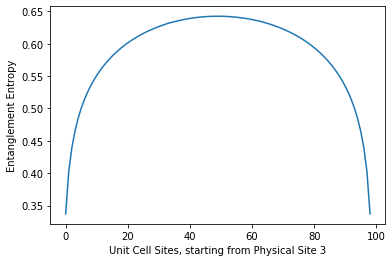

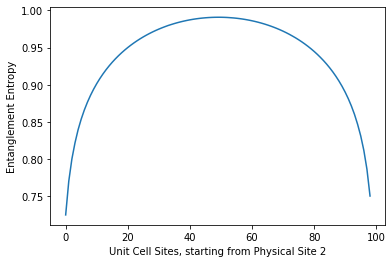

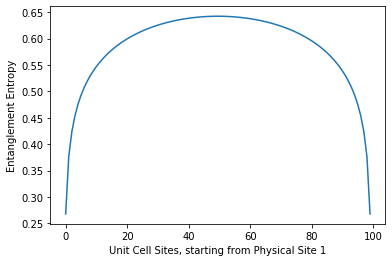

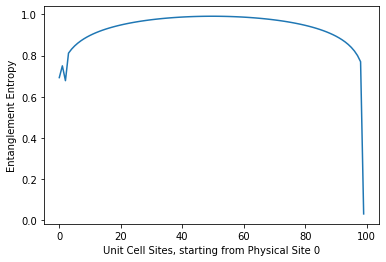

In [103]:
entanglement_entropy_raw = psi.entanglement_entropy()
# len(entanglement_entropy_raw)
start = 3
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 2
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 1
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

start = 0
plot( entanglement_entropy_raw[start:-1:4])
xlabel(f'Unit Cell Sites, starting from Physical Site {start}')
ylabel('Entanglement Entropy')
show()

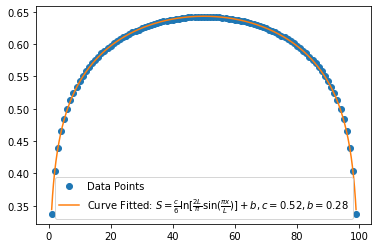

In [105]:
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

start = 3
entanglement_entropy = entanglement_entropy_raw[start:-1:4]
result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()


In [46]:
Jx = 1
Jy = 0
Jz = 1
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L, order='snake')

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 0.00, Jz = 1.00, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='snake' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=0 for config KitaevLadderModel
Reading 'Jz'=1 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=None for config DMRG
sweep 10, age = 400
Energy = -63.5712914968562188, S = 0.8121637555105646, norm_err = 5.2e-01
Current memory usage 296.4 MB, time elapsed: 126.0 s
Delta E = nan, Delta S = nan (per sweep)
max_trunc_err = 8.9757e-07, max_E_trunc = 1.5034e-06
MPS bond dimensions: [2, 2, 4, 4, 8, 8, 16, 16, 28, 22, 30, 26, 30, 30, 30, 30, 30, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 30 sweeps.
total size = 400, maximum chi = 30
E = -63.5712915271848
final bond dimensions:  [2, 2, 4, 4, 8, 8, 16, 16, 30, 25, 30, 26, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3

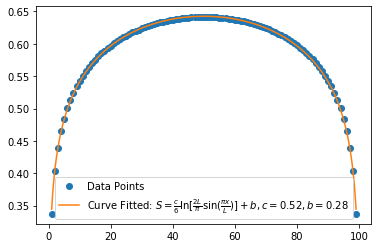

In [47]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [106]:
Jx = 1
Jy = 0.5
Jz = 0.5
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 0.50, Jz = 0.50, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=0.5 for config KitaevLadderModel
Reading 'Jz'=0.5 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -57.5167281318791552, S = nan, norm_err = 1.4e-03
Current memory usage 446.5 MB, time elapsed: 267.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.3050e-06, max_E_trunc = 3.3136e-06
MPS bond 

sweep 50, age = 400
Energy = -57.5167267950085446, S = 1.5480372203950594, norm_err = 4.7e-03
Current memory usage 446.5 MB, time elapsed: 675.7 s
Delta E = 3.0918e-07, Delta S = 1.3038e-05 (per sweep)
max_trunc_err = 2.1195e-06, max_E_trunc = 3.3133e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 60 sweeps.
total size = 400, maximum chi = 30
E = -57.5167268034291
final bond dimensions:  [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

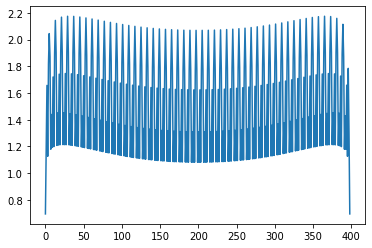

In [45]:
plot(psi.entanglement_entropy())

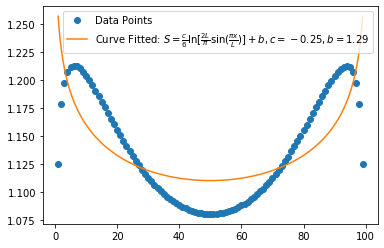

In [44]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [107]:
Jx = 1
Jy = 1
Jz = 0
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 1.00, Jz = 0.00, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=0 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -63.4797944589261931, S = nan, norm_err = 7.5e-04
Current memory usage 446.5 MB, time elapsed: 227.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.8729e-06, max_E_trunc = 5.6608e-06
MPS bond dime

sweep 50, age = 400
Energy = -63.4797962057382890, S = 1.0270625808234877, norm_err = 1.6e-04
Current memory usage 446.5 MB, time elapsed: 635.6 s
Delta E = 3.8320e-08, Delta S = 2.1483e-06 (per sweep)
max_trunc_err = 2.8699e-06, max_E_trunc = 5.5633e-06
MPS bond dimensions: [2, 2, 2, 4, 8, 8, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 50 sweeps.
total size = 400, maximum chi = 30
E = -63.4797962057383
final bond dimensions:  [2, 2, 2, 4, 8, 8, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

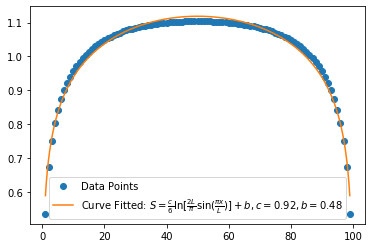

In [111]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

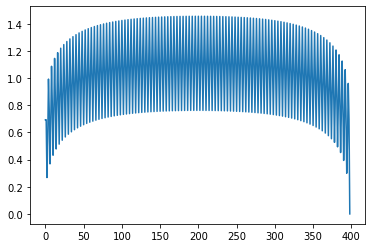

In [112]:
plot(psi.entanglement_entropy())

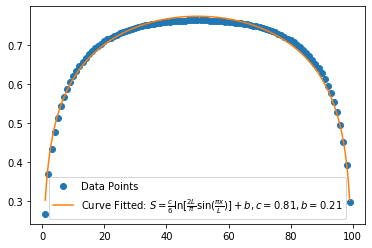

In [114]:
entanglement_entropy = psi.entanglement_entropy()[2:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [115]:
Jx = 1
Jy = 1
Jz = 0.2
L = 100
E, psi, M = fDMRG_KL(Jx, Jy, Jz, L)

finite DMRG, Kitaev ladder model
L = 100, Jx = 1.00, Jy = 1.00, Jz = 0.20, 
Reading 'L'=100 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'order'='default' for config KitaevLadderModel
Reading 'bc'='open' for config KitaevLadderModel
Reading 'bc_MPS'='finite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=0.2 for config KitaevLadderModel
bc_MPS =  finite
Reading 'combine'=True for config DMRG
Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config DMRG
Reading 'max_E_err'=1e-10 for config DMRG
Reading 'mixer'=True for config DMRG
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config DMRG
sweep 10, age = 400
Energy = -64.8160333950765022, S = nan, norm_err = 2.1e-04
Current memory usage 446.5 MB, time elapsed: 270.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5686e-06, max_E_trunc = 2.6514e-06
MPS bond di

Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 50, age = 400
Energy = -64.8160365173298629, S = 1.4740446238751050, norm_err = 1.3e-04
Current memory usage 446.5 MB, time elapsed: 722.8 s
Delta E = -6.9637e-10, Delta S = nan (per sweep)
max_trunc_err = 1.2644e-06, max_E_trunc = 2.6116e-06
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 60 sweeps.
total size = 400, maximum chi = 30
E = -64.8160365636668
final bond dimensions:  [2, 4, 8, 8, 16, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

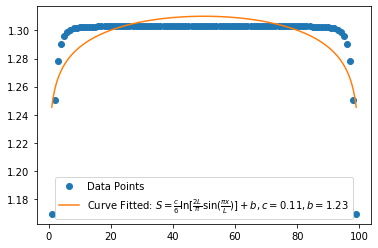

In [116]:
entanglement_entropy = psi.entanglement_entropy()[3:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

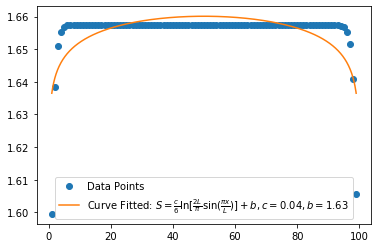

In [119]:
entanglement_entropy = psi.entanglement_entropy()[2:-1:4]
L_bond = L-1
sites = np.arange(L_bond) + 1
def func (x, c, b):
    return (c / 6) * np.log( (2 * L / np.pi) * np.sin( np.pi * x / L ) ) + b

result = curve_fit(func, sites, entanglement_entropy, p0=[.5, .26])
c, b = result[0]

plot(sites, entanglement_entropy, 'o', label='Data Points')

x = np.linspace(1, L_bond, 1000)
plot(x, func(x, c, b), label=r'Curve Fitted: $S=\frac{c}{6}\ln[\frac{2 L}{\pi} \sin (\frac{\pi x}{L})] + b, c=%.2f, b=%.2f$' % (c, b))
legend()
show()

In [8]:
Jx = -1
Jy = 1
Jz = 0

data = run_atomic(
    Jx=Jx,
    Jy=Jy,
    Jz=Jz,
    chi=100,
    L=2,
#     save_and_load=False,
#     plot=True,
)

Reading 'L'=2 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=0 for config KitaevLadderModel


==============================START==============================
Chi =  100 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
.....

Updating environment
.....
sweep 180, age = 4488
Energy = -0.1591548003883716, S = 1.1011108717598137, norm_err = 5.8e-06
Current memory usage 220.7 MB, time elapsed: 121.7 s
Delta E = -3.0796e-11, Delta S = 9.1048e-05 (per sweep)
max_trunc_err = 6.7240e-08, max_E_trunc = 1.3912e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100]
DMRG finished after 180 sweeps.
total size = 4488, maximum chi = 100
Before the canonicalization:
Bond dim =  [100, 100, 100, 100, 100, 100, 100, 100]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999987+2.76306602589132e-16j)
After the canonicalization:
Bond dim =  [100, 100, 100, 100, 100, 100, 100, 100]
Computing properties
Optimizing
Loop for chi=100 done.
============================== END ==============================


In [10]:
psi = data['psi']

next_data = run_atomic(
    Jx = Jx,
    Jy = Jy,
    Jz = Jz - 0.01,
    chi = 100,
    L = 2,
    max_sweeps=1000,
    initial_psi=psi,
)

Reading 'L'=2 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=-0.01 for config KitaevLadderModel


==============================START==============================
Chi =  100 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment


Updating environment
.....
sweep 180, age = 4488
Energy = -0.1591680666242468, S = 1.8956550432344328, norm_err = 2.5e-03
Current memory usage 236.3 MB, time elapsed: 161.5 s
Delta E = -4.4607e-09, Delta S = -3.2836e-03 (per sweep)
max_trunc_err = 4.6708e-07, max_E_trunc = 8.8028e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 190, age = 4728
Energy = -0.1591681324525354, S = 1.8270100949522843, norm_err = 3.0e-03
Current memory usage 236.5 MB, time elapsed: 167.9 s
Delta E = -6.5828e-09, Delta S = -6.8645e-03 (per sweep)
max_trunc_err = 4.5200e-07, max_E_trunc = 8.8686e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 200, age = 4968
Energy = -0.1591690855043737, S = 1.2638971754004142, norm_err = 1.3e-04
Current memory usage 236.5 MB, time elapsed: 175.5 s
Delta E = -9.5305e-08, Delta S = -5.6311e-02 (per sweep)
max_trunc_err = 5.2450e-08, max_E_trunc = 9.4218e-08
MPS bond dimensions: 

In [11]:
psi = next_data['psi']

next_data2 = run_atomic(
    Jx = Jx,
    Jy = Jy,
    Jz = Jz - 0.01,
    chi = 200,
    L = 2,
    max_sweeps=1000,
    initial_psi=psi,
)

Reading 'L'=2 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=-1 for config KitaevLadderModel
Reading 'Jy'=1 for config KitaevLadderModel
Reading 'Jz'=-0.01 for config KitaevLadderModel


==============================START==============================
Chi =  200 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment


In [33]:
L = 3
chi_list=[int(2**n) for n in np.arange(3, 9, .5)]
S_list, xi_list = finite_scaling(
    Jx = 1,
    Jy = -1,
    Jz = .05,
    L = L,
    chi_list=[int(2**n) for n in range(3, 9)],
    save_and_load=False,
    plot=False,
)

Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=0.05 for config KitaevLadderModel


==============================START==============================
Chi =  8 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment
..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
..
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


Before the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999998+2.471032780946199e-16j)
After the canonicalization:
Bond dim =  [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Computing properties
Optimizing
Loop for chi=8 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=0.05 for config KitaevLadderModel


==============================START==============================
Chi =  16 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEngine
Updating environment


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


..........
Reading 'N_sweeps_check'=5 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Updating environment
..
sweep 5, age = 420
Energy = -0.1591988445681102, S = nan, norm_err = 6.3e-04
Current memory usage 1546.3 MB, time elapsed: 5.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2122e-05, max_E_trunc = 4.6300e-05
MPS bond dimensions: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Updating environment
..
sweep 10, age = 588
Energy = -0.1592018541100562, S = nan, norm_err = 5.1e-05
Current memory usage 1546.3 MB, time elapsed: 8.1 s
Delta E = -6.0191e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2838e-05, max_E_trunc = 5.7443e-05
MPS bond dimensions: [16, 16, 16, 16, 16

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
..
Updating environment
..
Updating environment
..
Updating environment
..
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.02e-03
Call psi.canonical_form()
DMRG finished after 30 sweeps.
total size = 1500, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000033+8.326672684688674e-16j)
After the canonicalization:
Bond dim =  [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=0.05 for con

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [128, 128, 128, 128, 128, 128, 127, 128, 128, 128, 127, 128]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999976+1.478851763270228e-16j)
After the canonicalization:
Bond dim =  [128, 128, 128, 128, 128, 128, 127, 128, 128, 128, 127, 128]
Computing properties
Optimizing
Loop for chi=128 done.
============================== END ==============================
Reading 'L'=3 for config KitaevLadderModel
Reading 'conserve'=None for config KitaevLadderModel
Reading 'bc'='periodic' for config KitaevLadderModel
Reading 'bc_MPS'='infinite' for config KitaevLadderModel
Reading 'Jx'=1 for config KitaevLadderModel
Reading 'Jy'=-1 for config KitaevLadderModel
Reading 'Jz'=0.05 for config KitaevLadderModel


==============================START==============================
Chi =  256 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Initial sweeps...
Reading 'start_env'=10 for config TwoSiteDMRGEng

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2275: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2296: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(j1, Gl, Wr_list[j1 % L])


Before the canonicalization:
Bond dim =  [236, 256, 236, 256, 237, 256, 237, 256, 238, 256, 238, 256]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999936+3.707971429900425e-17j)
After the canonicalization:
Bond dim =  [236, 256, 236, 256, 237, 256, 237, 256, 238, 256, 238, 256]
Computing properties
Optimizing
Loop for chi=256 done.
============================== END ==============================


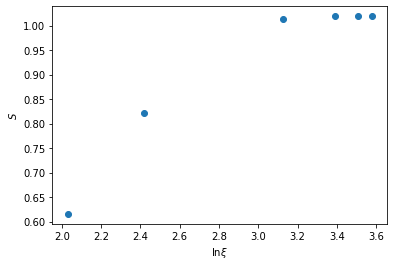

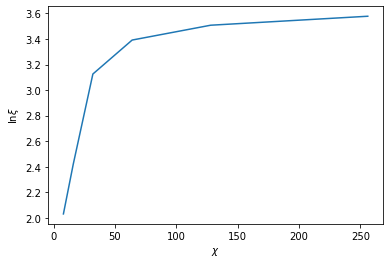

In [32]:
chi_list=[int(2**n) for n in range(3, 9)]

plot(np.log(xi_list), S_list, 'o')
xlabel(r'$\ln \xi$')
ylabel(r'$S$')
show()

plot(chi_list, np.log(xi_list))
xlabel(r'$\chi$')
ylabel(r'$\ln \xi$')
show()

In [ ]:
import matplotlib.pyplot as plt

NameError: name 'L' is not defined

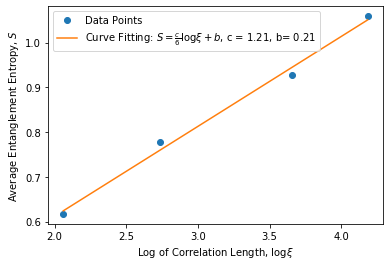

In [20]:
xs = np.log(xi_list)
ys = S_list

def func(log_xi, c, a):
    return (c / 6) * log_xi + a
fitParams, fitCovariances = curve_fit(func, xs, ys)

plt.plot(xs, ys, 'o', label='Data Points')
plt.xlabel(r'Log of Correlation Length, $\log\xi$')
plt.ylabel(r'Average Entanglement Entropy, $S$')

fitting_label = r'Curve Fitting: $S = \frac{c}{6}\log\xi + b$, c = %.2f, b= %.2f' % (fitParams[0], fitParams[1])
plt.plot(xs, func(xs, fitParams[0], fitParams[1]), label=fitting_label)

plt.legend()
title_name = f'Finite Scaling at J = ({Jx}, {Jy}, {Jz}), L={L}'
plt.title(title_name)

plt.show()